In [1]:
import pyspark as ps
import numpy as np
import socket
import platform
import pandas as pd
from pyspark.sql import SQLContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql.functions import udf, col, when
import matplotlib.pyplot as plt

In [2]:
appName = "Recommender system in Spark"
spark = ps.sql.SparkSession.builder\
            .master("local") \
            .appName("Book Recommendation Engine") \
            .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

23/12/19 14:10:19 WARN Utils: Your hostname, macbooks-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.12.67.138 instead (on interface en0)
23/12/19 14:10:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/19 14:10:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/19 14:10:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/Users/parthvi/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
def get_Host_name_IP(): 
    try: 
        host_name = socket.gethostname() 
        host_ip = socket.gethostbyname(host_name) 
        print("Hostname :  ",host_name) 
        print("IP : ",host_ip) 
    except: 
        print("Unable to get Hostname and IP")
        
get_Host_name_IP()

Hostname :   macbooks-MacBook-Pro-2.local
IP :  127.0.0.1


In [4]:
print("Computer Config")
system_conf = platform.uname()

print(f"System: {system_conf.system}")
print(f"Node Name: {system_conf.node}")
print(f"Release: {system_conf.release}")
print(f"Version: {system_conf.version}")
print(f"Machine: {system_conf.machine}")
print(f"Processor: {system_conf.processor}")

Computer Config
System: Darwin
Node Name: macbooks-MacBook-Pro-2.local
Release: 23.1.0
Version: Darwin Kernel Version 23.1.0: Mon Oct  9 21:27:27 PDT 2023; root:xnu-10002.41.9~6/RELEASE_X86_64
Machine: x86_64
Processor: i386


In [5]:
ratings = spark.read.csv(r"/Users/parthvi/Desktop/B-16 BDMS Final Project Book Recommendation System/Book Recomendation System/dataset/ratings.csv", header=True, inferSchema=True) 
ratings.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [6]:
ratings.show(10)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
|      1|   2077|     4|
|      1|   2487|     4|
|      1|   2900|     5|
|      1|   3662|     4|
|      1|   3922|     5|
+-------+-------+------+
only showing top 10 rows



In [7]:
books = spark.read.csv(r"/Users/parthvi/Desktop/B-16 BDMS Final Project Book Recommendation System/Book Recomendation System/dataset/books.csv", header=True, inferSchema=True) 
books.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- work_ratings_count: string (nullable = true)
 |-- work_text_reviews_count: string (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = true)


In [8]:
books.show(5)

+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------

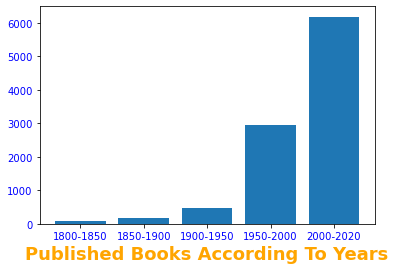

Text(0.5, 0, 'Published Books According To Years')

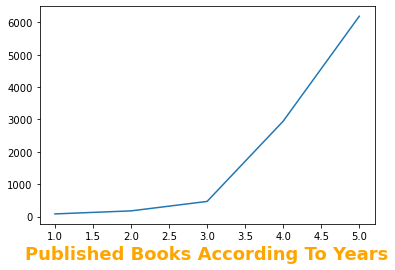

In [9]:
#print(books.toPandas()['original_publication_year'].unique().shape)
books_pandas = books.toPandas()
l1_count = books_pandas[(books_pandas['original_publication_year'] >= 1800) & (books_pandas['original_publication_year'] < 1850)]
l2_count = books_pandas[(books_pandas['original_publication_year'] >= 1850) & (books_pandas['original_publication_year'] < 1900)]
l3_count = books_pandas[(books_pandas['original_publication_year'] >= 1900) & (books_pandas['original_publication_year'] < 1950)]
l4_count = books_pandas[(books_pandas['original_publication_year'] >= 1950) & (books_pandas['original_publication_year'] < 2000)]
l5_count = books_pandas[(books_pandas['original_publication_year'] >= 2000) & (books_pandas['original_publication_year'] < 2020)]

height = [l1_count.shape[0], l2_count.shape[0], l3_count.shape[0], l4_count.shape[0], l5_count.shape[0]]
 
bars = ('1800-1850', '1850-1900', '1900-1950', '1950-2000', '2000-2020')
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height)
 
plt.xticks(y_pos, bars, color='blue')
plt.yticks(color='blue')
plt.xlabel('Published Books According To Years', fontweight='bold', color = 'orange', fontsize='18')

plt.show()

# print line plot.
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([1, 2, 3, 4, 5], [l1_count.shape[0], l2_count.shape[0], l3_count.shape[0], l4_count.shape[0], l5_count.shape[0]])  # Plot some data on the axes.
plt.xlabel('Published Books According To Years', fontweight='bold', color = 'orange', fontsize='18')



In [10]:
training, validation = ratings.randomSplit([.7,.3])

In [11]:
als =ALS(maxIter=2,regParam=0.01, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

23/12/19 14:10:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/19 14:10:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/12/19 14:10:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Mean Squared Error =16.553505205864397


In [12]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|   2077|     4| 4.6486373|
|      1|   2487|     4| 4.2219725|
|      1|   2900|     5| 5.1530986|
|      1|   5379|     5| 4.9596972|
|      1|   9246|     1| 3.5410864|
|      1|  10140|     4| 3.7206056|
|      1|  13544|     5|  4.460279|
|      1|  16913|     5| 4.7431464|
|      1|  18361|     4|  4.510079|
|      1|  21487|     4|  4.661577|
+-------+-------+------+----------+
only showing top 10 rows



In [13]:
pred_arr = predictions.toPandas()

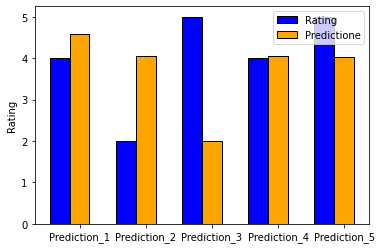

In [14]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [15]:
als =ALS(maxIter=5,regParam=0.1, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =1.059908568286947


In [16]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|   2077|     4|  3.381993|
|      1|   2487|     4| 3.8131998|
|      1|   2900|     5|  4.550149|
|      1|   5379|     5|  4.584486|
|      1|   9246|     1| 3.2708013|
|      1|  10140|     4| 3.3992522|
|      1|  13544|     5|  4.481768|
|      1|  16913|     5| 4.2602262|
|      1|  18361|     4|  4.501608|
|      1|  21487|     4|  4.142337|
+-------+-------+------+----------+
only showing top 10 rows



In [17]:
pred_arr = predictions.toPandas()

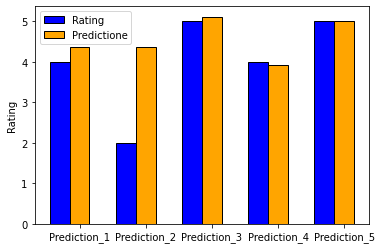

In [18]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [19]:
als =ALS(maxIter=7,regParam=0.1, rank=50, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.8542219423945872


In [20]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|   2077|     4|  3.608637|
|      1|   2487|     4| 3.6337185|
|      1|   2900|     5| 4.5546184|
|      1|   5379|     5| 4.3425703|
|      1|   9246|     1| 3.3290753|
|      1|  10140|     4| 3.6078258|
|      1|  13544|     5| 4.5421185|
|      1|  16913|     5|  4.308497|
|      1|  18361|     4| 4.4152455|
|      1|  21487|     4|  4.119829|
+-------+-------+------+----------+
only showing top 10 rows



In [21]:
pred_arr = predictions.toPandas()

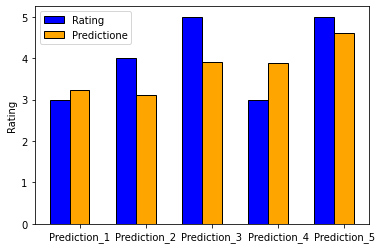

In [22]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [23]:
als =ALS(maxIter=10,regParam=0.01, rank=100, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.9104310067631112


In [24]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|   2077|     4| 2.5967736|
|      1|   2487|     4| 3.0640447|
|      1|   2900|     5| 3.8602357|
|      1|   5379|     5| 4.4412518|
|      1|   9246|     1| 3.0092092|
|      1|  10140|     4| 4.3869557|
|      1|  13544|     5| 4.2768254|
|      1|  16913|     5|  3.775726|
|      1|  18361|     4|  4.477097|
|      1|  21487|     4| 4.6634073|
+-------+-------+------+----------+
only showing top 10 rows



In [25]:
pred_arr = predictions.toPandas()

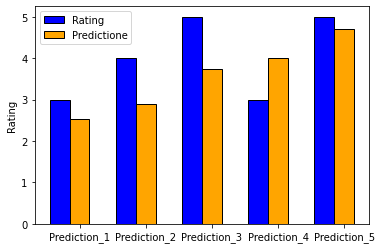

In [26]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [27]:
predictions.join(books, "book_id").select("user_id","title","prediction").show(5)

+-------+-----------------+----------+
|user_id|            title|prediction|
+-------+-----------------+----------+
|    859|       Lysistrata| 3.2062964|
|   1291| The Fountainhead| 3.0014052|
|   1374|       Lysistrata|  3.851608|
|   1855|Heart of Darkness| 3.4440374|
|   2327|Heart of Darkness| 3.7563105|
+-------+-----------------+----------+
only showing top 5 rows



In [28]:
forOneUser = predictions.filter(col("user_id")==35982).join(books,"book_id").select("user_id","title","image_url","prediction")

In [29]:
forOneUser.count()

5

In [30]:
forOneUser.show()

+-------+--------------------+--------------------+----------+
|user_id|               title|           image_url|prediction|
+-------+--------------------+--------------------+----------+
|  35982|The Innocent Man:...|https://s.gr-asse...| 1.7509767|
|  35982|The Door Into Summer|https://images.gr...| 1.7794337|
|  35982|  Great Expectations|https://images.gr...| 2.2799687|
|  35982|       Metamorphoses|https://s.gr-asse...|  2.939971|
|  35982|J.R.R. Tolkien 4-...|https://images.gr...| 2.2897038|
+-------+--------------------+--------------------+----------+



In [31]:
from IPython.display import display
from IPython.display import Image
for book in forOneUser.take(10):
    print(book.title)
    display(Image(url=book.image_url))

The Innocent Man: Murder and Injustice in a Small Town


The Door Into Summer


Great Expectations


Metamorphoses


J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings


In [32]:
#Generate top 5 books recommendations for each user
userRecomments = model.recommendForAllUsers(5)
#Generate top 5 user recommendations for each book
bookRecomments = model.recommendForAllItems(5)

In [33]:
userRecomments.select("user_id","recommendations.book_id").show(10,False)

+-------+------------------------------+
|user_id|book_id                       |
+-------+------------------------------+
|1      |[1180, 7844, 8013, 4778, 6583]|
|2      |[9529, 7844, 9249, 4366, 6583]|
|3      |[9014, 7337, 4366, 7844, 7920]|
|4      |[8464, 9566, 7844, 9842, 7117]|
|5      |[7487, 9842, 6659, 8333, 6583]|
|6      |[7844, 8033, 6884, 7902, 6400]|
|7      |[4336, 1462, 8320, 3314, 5993]|
|8      |[7117, 7947, 9566, 4778, 7844]|
|9      |[3885, 8362, 8233, 8676, 8323]|
|10     |[8595, 6590, 3753, 8013, 6920]|
+-------+------------------------------+
only showing top 10 rows



In [34]:
userRecomments.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- book_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [35]:
bookRecomments.select("book_id","recommendations.user_id").show(10,False)

+-------+-----------------------------------+
|book_id|user_id                            |
+-------+-----------------------------------+
|1      |[22740, 8400, 21447, 20634, 33093] |
|2      |[36919, 22740, 8222, 1794, 19984]  |
|3      |[7443, 40566, 32918, 49288, 18492] |
|4      |[51235, 19984, 46524, 50266, 22740]|
|5      |[46524, 17703, 16750, 51235, 11489]|
|6      |[32346, 29132, 9752, 27585, 39879] |
|7      |[1456, 15082, 8222, 46524, 43692]  |
|8      |[51235, 49631, 26753, 36919, 9142] |
|9      |[8444, 3445, 20814, 13697, 31887]  |
|10     |[47756, 6097, 17703, 52366, 10011] |
+-------+-----------------------------------+
only showing top 10 rows



In [36]:
#Generate top 10 book recommendations for a specified set of users
users = ratings.select("user_id").distinct().limit(3);
users.show()

+-------+
|user_id|
+-------+
|  32592|
|  19984|
|  35982|
+-------+



In [37]:
userSubsetRecs = model.recommendForUserSubset(users,10)

In [38]:
userSubsetRecs.show()

In [ ]:
userSubsetRecs.select("user_id","recommendations.book_id").show(10,False)

+-------+------------------------------------------------------------+
|user_id|book_id                                                     |
+-------+------------------------------------------------------------+
|32592  |[3753, 9076, 1597, 6902, 1308, 862, 1274, 2101, 3628, 4868] |
|35982  |[983, 5580, 5207, 7254, 3628, 7593, 1788, 6590, 2869, 6361] |
|19984  |[3753, 9076, 6902, 9842, 8548, 3628, 6920, 3491, 1618, 1010]|
+-------+------------------------------------------------------------+



In [ ]:
#Generate top 10 user recommendations for a specified set of books
book1 = ratings.select("book_id").distinct().limit(3)
book1.show()

+-------+
|book_id|
+-------+
|    148|
|    463|
|    471|
+-------+



In [ ]:
bookSubSetRecs = model.recommendForItemSubset(book1, 10)
bookSubSetRecs.select("book_id","recommendations.user_id").show(10,False)

+-------+----------------------------------------------------------------------+
|book_id|user_id                                                               |
+-------+----------------------------------------------------------------------+
|471    |[12912, 22313, 13006, 18102, 4134, 30184, 19941, 24073, 33099, 33969] |
|463    |[22313, 44191, 49830, 41421, 19137, 52469, 42125, 22186, 39979, 30653]|
|148    |[22313, 11193, 13006, 33969, 7868, 46421, 8643, 19984, 32996, 23487]  |
+-------+----------------------------------------------------------------------+



In [ ]:
#Prediction for a user and match with to-read list
book_ids = [860,1524,2885,2914,5297,7397,8802,9506]
user_ids = [4917,4917,4917,4917,4917,4917,4917,4917]
new_user_preds = sqlContext.createDataFrame(zip(book_ids,user_ids), schema = ['book_id','user_id'])

In [ ]:
new_user_preds.show()

+-------+-------+
|book_id|user_id|
+-------+-------+
|    860|   4917|
|   1524|   4917|
|   2885|   4917|
|   2914|   4917|
|   5297|   4917|
|   7397|   4917|
|   8802|   4917|
|   9506|   4917|
+-------+-------+



In [ ]:
new_predictions = model.transform(new_user_preds)
new_predictions.show()

+-------+-------+----------+
|book_id|user_id|prediction|
+-------+-------+----------+
|   2914|   4917| 2.8714437|
|    860|   4917| 3.5368922|
|   2885|   4917|  3.168972|
|   7397|   4917| 3.0444274|
|   8802|   4917| 3.2045946|
|   9506|   4917|  3.124133|
|   1524|   4917| 3.6029627|
|   5297|   4917|  3.391838|
+-------+-------+----------+

